# Example of spectral integrals: gravity upward continuation 

In the first notebook, we showed how to generate a spectral form of integrals over a single axis. An important application of this proceedure the in spectral domain calculation of gravity anomalies, also known as upward continuation. Given a known subsurface density structure $\rho(x,y)$, the surface (upward continued) gravity signal can be written as:

$ \Delta g (x) = 2\pi G \left[ \sum_k e^{ikx} \int_{z_0}^{z_t} \hat \Gamma(k,z)e^{-kz} dz  \right]$

Where:

* $\hat \Gamma$ is the spectral representation of the density in the horizontal axis

* $e^{-kz}$ is sometimes called the the upward continuation kernel

* for 2D domains, the spectral representation given above assumes the density structure is constant in the 3rd dimension (hence we compare with solutions to a a cylinder not a sphere!)


We will compare this upward continuation proceedure with the analytic solution for gravity above a cylinder. The $g_z$ component of the gravity is:

$$\Delta g_z = \frac{2 \pi G R^2 \Delta \rho z}{(x^2 + z^2)}$$

## A function for spectral integrals.

First let's package up some of the code we used in the first notebook, extending it to also inlcude a "kernel" function.




In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
from scipy.integrate import simps, trapz
import numpy as np

In [2]:
def spectral_integral(mesh, fnToInt, N, axisIndex=0, kernelFn=1., average = True, 
                      integrationType="volume",surfaceIndexSet=None, returnCoeffs=False ):
    """
    Returns a vector-valued function that represents the spectral integral over one of the UW mesh axes. 
    The axis over which the intragration is performed is, by definition, 
    parallel to the axisIndex
    (the sin cosine modes are created orthogonal the axisIndex).
    
    A scalar or vector valued kernel function can be provided, 
    for instance, the upward continuation kernel used in potential field reconstuction
    
    N is the number of wavenumber used, inlcudingh the zeroth mode (average value)
    
    """
    
    if integrationType:
        if not isinstance( integrationType, str ):
            raise TypeError( "'integrationType' provided must be a string.")
        integrationType = integrationType.lower()
        if integrationType not in ["volume", "surface"]:
            raise ValueError( "'integrationType' string provided must be either 'volume' or 'surface'.")
    if integrationType == "surface":
        if not surfaceIndexSet:
                    raise RuntimeError("For surface integration, you must provide a 'surfaceIndexSet'.")
    
    if axisIndex == 0:
        modeaxes = 1
    elif axisIndex == 1:
        modeaxes = 0
    else:
        raise ValueError( "axisIndex must either of 0 or 1")
    
    #determine average, and edge cases 
    if average:
        average_ = uw.utils.Integral(fnToInt*kernelFn,mesh)
    else:
        average_ = uw.utils.Integral(fn.misc.constant(0.), mesh)
    
    if N <=2:
        raise ValueError( "N must be at least 2, otherwise you should use an integral (N=1)")

        
    
    # create set of wavenumbers / modes
    res = mesh.elementRes[modeaxes]
    width = abs(mesh.maxCoord[modeaxes] - mesh.minCoord[modeaxes])
    ax_ = fn.coord()[modeaxes]
    modes = []
    #ks = []
    for i in range(1,N):
        factor = float(i)*2.*np.pi/width
        modes.append(factor*ax_)
        #ks.append(factor)
        
    sinfns = fn.math.sin(modes)
    cosfns = fn.math.cos(modes)
    
    
    if average:
        average_ = uw.utils.Integral(fnToInt*kernelFn,mesh)
    else:
        average_ = fn.misc.constant(0.)
    
    if integrationType=="volume":
        sin_coeffs = uw.utils.Integral(fnToInt*kernelFn*sinfns,mesh)
        cos_coeffs = uw.utils.Integral(fnToInt*kernelFn*cosfns,mesh)

    else:
        
        sin_coeffs = uw.utils.Integral(fnToInt*kernelFn*sinfns, mesh, 
                                        integrationType='surface', 
                                       surfaceIndexSet=surfaceIndexSet)
        cos_coeffs = uw.utils.Integral(fnToInt*kernelFn*sinfns, mesh, 
                                        integrationType='surface', 
                                       surfaceIndexSet=surfaceIndexSet) 

    synthFn = (2./width)*fn.math.dot(sin_coeffs.evaluate(),sinfns) + \
              (2./width)*fn.math.dot(cos_coeffs.evaluate(),cosfns) + \
                         average_.evaluate()[0]
    
    if not returnCoeffs:
        return synthFn
    else:
        return synthFn, [sin_coeffs, cos_coeffs]
    
    
def integral_wavenumbers(mesh, N, axisIndex=0):
    
    if axisIndex == 0:
        modeaxes = 1
    elif axisIndex == 1:
        modeaxes = 0
    else:
        raise ValueError( "axisIndex must either of 0 or 1")
        
    if N <=2:
        return np.array([0])
    
    #res = mesh.elementRes[modeaxes]
    width = mesh.maxCoord[modeaxes] - mesh.minCoord[modeaxes]

    ks = []
    for i in range(1,N):
        factor = float(i)*2.*np.pi/width
        ks.append(factor)
    return(np.array(ks))

## Set up problem in Underworld2

In [3]:
lengthScale = 2900e3
# first create a mesh and variable
mesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                elementRes=(6*64,64),
                                minCoord    = (-1., 1. - 1000e3/lengthScale), 
                                maxCoord    = (1., 1.) )


densVar = uw.mesh.MeshVariable(mesh,1)

In [33]:
#set up a circle function (cylinders)
radius = 150e3/lengthScale
depth =  400e3/lengthScale
offset= (0., 1 - depth)
coord1 = fn.input() - offset 

circle1 = ( fn.math.dot(coord1,coord1) < radius**2 )



In [34]:
densFn = fn.branching.conditional(  ( (circle1,  1.),
                                              (        True, 0.)   ) )

densVar.data[:] = densFn.evaluate(mesh)


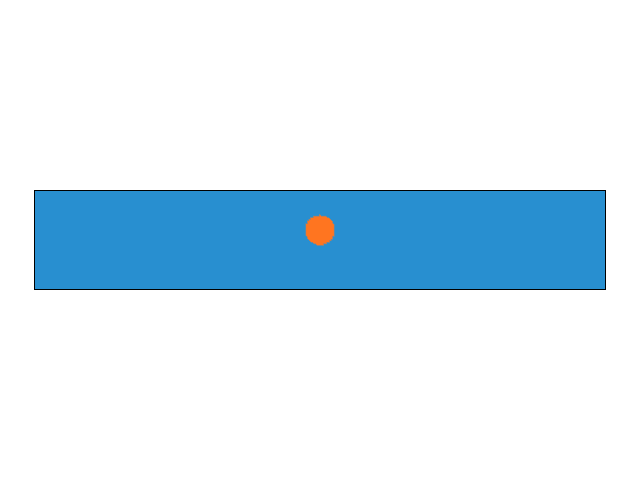

In [35]:
fig = glucifer.Figure(quality=0)
fig.append( glucifer.objects.Surface(mesh, densVar, onMesh=True, colourBar=False) )
fig.show()

## Analytic solution, dimensional values




In [36]:
G = 6.67e-11         #grav. constant
rho = 3300.0         #density
deltaRho = 50.       #kg/m**3

In [37]:
meshXs = mesh.data[mesh.specialSets['MaxJ_VertexSet'].data][:,0]

In [38]:
dimXs = (meshXs - offset[0])*lengthScale

dimDepth = depth*lengthScale
dimrad = radius*lengthScale

grav = ((2*np.pi*G*(dimrad)**2*deltaRho))*dimDepth/((dimXs**2 + dimDepth**2))


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


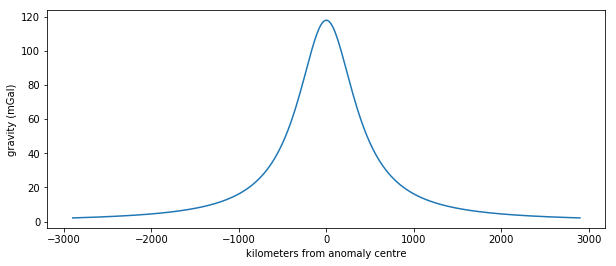

In [39]:
%pylab inline
fig, ax = plt.subplots(figsize=(10, 4))

gravComb = (grav)

ax.plot(dimXs*1e-3, gravComb *1e5)
ax.set_ylabel('gravity (mGal)')
ax.set_xlabel('kilometers from anomaly centre')

## Upward Continuation
       

In [40]:
densityIntFac = deltaRho*lengthScale
gravitationalFac = 2.*np.pi*G

In [41]:
N = 6   
ks = integral_wavenumbers(mesh, N, axisIndex=1)
upContKernelFn = fn.math.exp(-1.*(1. - fn.coord()[1])*ks)
ks

array([  3.14159265,   6.28318531,   9.42477796,  12.56637061,  15.70796327])

In [42]:
synthFn, coeffs = spectral_integral(mesh, densVar, N=N, axisIndex=1, kernelFn=upContKernelFn, average = True, 
                      integrationType="volume",surfaceIndexSet=None, returnCoeffs=True )

In [43]:
meshxs= mesh.data[mesh.specialSets['MaxJ_VertexSet'].data][:,0]

evals = np.column_stack( (meshxs, np.ones(len(meshxs)) ))
gravFn = synthFn.evaluate(evals )

#Now dimensionalize
gravFn = gravFn*densityIntFac*gravitationalFac

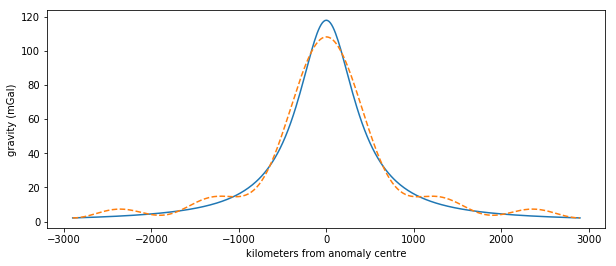

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dimXs*1e-3, gravComb*1e5)
ax.plot(dimXs*1e-3, ((gravFn) - ((gravFn)[0]  -gravComb[-1]))  *1e5, ls = '--')

ax.set_ylabel('gravity (mGal)')
ax.set_xlabel('kilometers from anomaly centre')

In [45]:
sincfs = coeffs[0].evaluate()
coscfs = coeffs[1].evaluate()

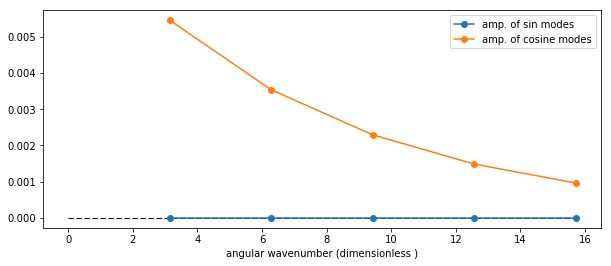

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(ks,sincfs ,label = 'amp. of sin modes', marker='o'  )
ax.plot(ks,coscfs, label = 'amp. of cosine modes' , marker='o' )
ax.legend()
ax.hlines(0,0, ks[-1], linestyles='--', lw=1. )
ax.set_xlabel('angular wavenumber (dimensionless )')

## Upward continuation via numpy FFT

Here we demonstrate the other way of performing the upward continuation - via the Numpy FFT module

* While this is significantly faster, it can only be performed in serial, with a uniform mesh. 

In [48]:
dm = 20e3/lengthScale

mesh.minCoord[0]
mesh.maxCoord[0]

nx =  (mesh.maxCoord[0]- mesh.minCoord[0])/dm
meshxs = 0.99999999*np.linspace(mesh.minCoord[0], mesh.maxCoord[0], int(nx), endpoint=True)
ny =  (1200e3/lengthScale)/dm

meshys = np.linspace(mesh.minCoord[1], 1. , int(ny),  endpoint=True)
xv, yv = np.meshgrid(meshxs, meshys )
coords = np.array(zip(xv.flatten(), yv.flatten()))#uw just wants an Mx2 array

In [49]:
densdata = densVar.evaluate(coords[:, :])[:,0]
density = np.zeros(xv.shape) 
density[:] = densdata.reshape((xv.shape))

In [50]:
#set up wavenumbers and perform the FFT

N  = density.shape[1]
spacing = meshxs[1] - meshxs[0] 
kvals = 2.*np.pi*np.fft.rfftfreq(N, d=spacing )
density_k = np.fft.rfft(density)

In [51]:
#set up the upward continuation kernel

depths = 1. - meshys 
#create the exponent for the upward continuation kernel
expon = np.outer(depths, np.abs(kvals))
#create the upward continuation kernel 
kernelMatrix = np.exp(-1.*expon)

In [52]:
#apply  the upward continuation kernel,  
Kernel = -1*kernelMatrix*density_k
dy = meshys[0] - meshys[1]

#and integrate vertical contrubutions for each wavenumber
densSum = simps(Kernel, x = depths, axis=0)


#set the mean value to zero
mask = kvals == 0
densSum[mask] = 0


gravFFT_ = np.fft.irfft(densSum)
gravFFT = gravFFT_*densityIntFac*gravitationalFac

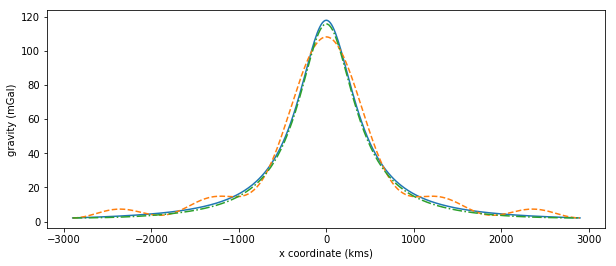

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dimXs*1e-3, gravComb*1e5)
ax.plot(dimXs*1e-3, ((gravFn) - ((gravFn)[0]  -gravComb[-1]))  *1e5, ls = '--')
ax.plot(meshxs[:]*lengthScale*1e-3, (gravFFT - ((gravFFT)[0]  -gravComb[-1]))*1e5, ls = '-.')


ax.set_ylabel('gravity (mGal)')
ax.set_xlabel('x coordinate (kms)')